# Sensitivity Plot Maker

In [1]:
# Import requisite modules
import sys
sys.path.append("../SimulationCode")
import astropy.units as u
import astropy.constants as c
import BaryakhtarFunctions as func
import numpy as np
import matplotlib.pyplot as plt
import superrad as sr
import superrad.harmonics as har
import Config as conf
# Set plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
alpha = 0.8

## Combined h0 Plot Making
### MOA-2011

In [2]:
# Define correction factor from angular-averaged value (see AngularDistributionPlotMaker)
ang_corr_factor = 0.3561962678776969

# Read in sensitivity curves
sens_dict = func.read_in_sensitivity_curves("SensitivityCurves/") # Note this corrects for the triangular configuration of ET
# Add extra curve for Lilli's PSD
sens_dict["o2_real"] = func.read_in_lilli_sensitivity_curves("o2-psd-H1L1.txt")

# Read in detection bounds from Isi et al.
ref_frequencies = [201.2]
ref_h0_bounds = [4.7e-26]
ref_ASDs = [4e-24]

# Define curves to find prospective sensitivity
curves_of_interest = ["o2","o2_real","aligo_design","ce2","et_d","decigo","magiss-r"]
# Define dictionary to store bounds
h0_211_bounds_dict = dict()
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = []
    for val in ref_frequencies:
        h0_211_bounds_dict[curve].append(np.zeros_like(sens_dict[curve][0]))
        
# Find prospective sensitivity for each curve
for curve in curves_of_interest:
    freq_list = sens_dict[curve][0]
    ASD_list = sens_dict[curve][1]
    for i in range(len(ref_frequencies)):
        ref_freq = ref_frequencies[i]
        ref_h0_bound = ref_h0_bounds[i]
        ref_ASD = ref_ASDs[i]
        for k in range(len(freq_list)):
            freq = freq_list[k]
            ASD = ASD_list[k]
            # Scale and store value
            if curve == "o2_real":
                T_obs_scale = (233/80)
            else:
                T_obs_scale = (365/80)
            T_coh_scale = 10/8
            h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(ASD/ref_ASD)*\
            (T_coh_scale*T_obs_scale)**(-1/4)*(2)**0.5

for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = h0_211_bounds_dict[curve][0]*ang_corr_factor
    
h0_211_bounds_dict_MOA = {}
for key in h0_211_bounds_dict:
    h0_211_bounds_dict_MOA[key] = h0_211_bounds_dict[key]
h0_tr_bounds_dict_MOA = {} 
for key in h0_211_bounds_dict:
    h0_tr_bounds_dict_MOA[key] = h0_211_bounds_dict[key]

### Cygnus X-1

In [3]:
# Compute angular distribution correction factor
iota = 27.1*(2*np.pi/360)

# For 211
def ang_211_power(N_211,alpha,theta,bhm):
    r_g = func.G*bhm*func.M_sol/func.c**2
    const = 9*func.G*func.hbar**2/(2**26*func.c)
    scale = N_211**2*alpha**18/r_g**4
    angular_dependence = (35+28*np.cos(2*theta)+np.cos(4*theta))
    return const*scale*angular_dependence
# Define angle
theta_in_pi = np.linspace(0,1,num=101)
theta = theta_in_pi*np.pi
# Compute max vs. integral
ang_211_template = ang_211_power(1e76,0.1,theta,10)
auc = np.trapz(np.sin(theta)*ang_211_template)
max_v_auc_211 = max(ang_211_template)/auc
h_factor_211 = ((ang_211_power(1e76,0.1,iota,10)/auc)/max_v_auc_211)**0.5

print(h_factor_211)

0.8932311943750108


In [4]:
def find_match_index(x,x_list):
    if x < min(x_list):
        return 0
    elif x > max(x_list):
        return -1
    else:
        i = 0
        for j in range(len(x_list)):
            if x_list[j] <= x:
                i = j
        return i

# Read in sensitivity curves
sens_dict = func.read_in_sensitivity_curves("SensitivityCurves/")
# Add extra curve for Lilli's PSD
sens_dict["o2_real"] = func.read_in_lilli_sensitivity_curves("o2-psd-H1L1.txt")

# Read in detection bounds for O2 Search on Cygnus
ref_frequencies = [255.5, 355.5, 441.5, 573.5, 665.5, 735.5]
ref_h0_bounds = [3.9e-25, 4.8e-25, 5.7e-25, 7.2e-25, 8e-25, 8.8e-25]

# Define curves to find prospective sensitivity
curves_of_interest = ["o2","o2_real","aligo_design","ce2","et_d","decigo","magiss-r"]
# Define dictionary to store bounds
h0_211_bounds_dict = dict()
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = []
    for val in ref_frequencies:
        h0_211_bounds_dict[curve].append(np.zeros_like(sens_dict[curve][0]))
        
# Find prospective sensitivity for each curve
for curve in curves_of_interest:
    freq_list = sens_dict[curve][0]
    ASD_list = sens_dict[curve][1]
    for i in range(len(ref_frequencies)):
        ref_freq = ref_frequencies[i]
        ref_h0_bound = ref_h0_bounds[i]
        # Determine matching sensitivity from Lilli's O2 Sensitivity data
        j = find_match_index(ref_freq,sens_dict["o2_real"][0])
        ref_ASD = sens_dict["o2_real"][1][j]
        for k in range(len(freq_list)):
            freq = freq_list[k]
            ASD = ASD_list[k]
            if curve == "o2_real":
                T_obs_scale = (233/233)
            else:
                T_obs_scale = (365/233) # (233/80)**2
            # Scale and store value
            if curve == "o2_real":
                h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(ASD/ref_ASD)*(T_obs_scale)**(-1/4)*(freq/ref_freq)**(1/4)
            else:
                h0_211_bounds_dict[curve][i][k] = ref_h0_bound*(ASD/ref_ASD)*(T_obs_scale)**(-1/4)*2**0.5

# Scaling from just the lowest frequency
for curve in curves_of_interest:
    h0_211_bounds_dict[curve] = h0_211_bounds_dict[curve][0]
    
h0_211_bounds_dict_Cyg = {}
for key in h0_211_bounds_dict:
    h0_211_bounds_dict_Cyg[key] = h0_211_bounds_dict[key]*h_factor_211
h0_tr_bounds_dict_Cyg = {} 
for key in h0_211_bounds_dict:
    h0_tr_bounds_dict_Cyg[key] = h0_211_bounds_dict[key]*h_factor_211

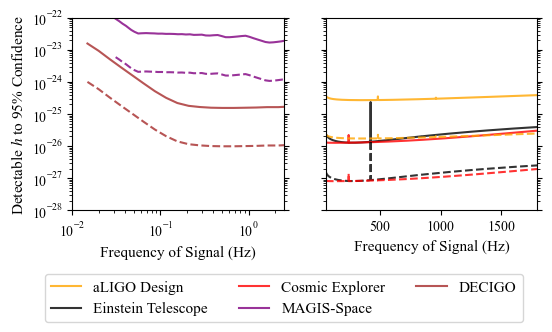

In [5]:
import matplotlib.ticker as ticker

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,2.5),sharey=True)
#ax1.scatter(ref_frequencies, ref_h0_bounds, s=25, marker = "o", facecolor="none",edgecolor="black",label="Scaling Points")
#ax1.plot(frequency, h0_211_bound, "k--")
ax1.plot(sens_dict["o2_real"][0],h0_211_bounds_dict_Cyg["o2_real"],label="O2 aLIGO (Searched)",color=conf.line_dic["o2_real"][0],linestyle=conf.line_dic["o2_real"][1])
ax1.plot(sens_dict["aligo_design"][0],h0_211_bounds_dict_Cyg["aligo_design"],label="aLIGO Design",color=conf.line_dic["aligo_design"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["aligo_design"][1])
# Dummy line for placing the label
ax1.plot([],[],label="Einstein Telescope",color=conf.line_dic["et_d"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["et_d"][1])
ax1.plot(sens_dict["ce2"][0],h0_211_bounds_dict_Cyg["ce2"],label="Cosmic Explorer",color=conf.line_dic["ce2"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["ce2"][1])
ax1.plot(sens_dict["magiss-r"][0],h0_211_bounds_dict_Cyg["magiss-r"],label="MAGIS-Space",color=conf.line_dic["magiss-r"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["magiss-r"][1])
ax1.plot(sens_dict["decigo"][0],h0_211_bounds_dict_Cyg["decigo"],label="DECIGO",color=conf.line_dic["decigo"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["decigo"][1])

ax1.plot(sens_dict["aligo_design"][0],h0_211_bounds_dict_MOA["aligo_design"],label="O4 LIGO",color=conf.line_dic["aligo_design"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["aligo_design"][1])
#ax1.plot(sens_dict["et_d"][0],h0_211_bounds_dict_MOA["et_d"],label="Einstein Telescope",color=conf.line_dic["et_d"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["et_d"][1])
ax1.plot(sens_dict["ce2"][0],h0_211_bounds_dict_MOA["ce2"],label="Cosmic Explorer",color=conf.line_dic["ce2"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["ce2"][1])
ax1.plot(sens_dict["magiss-r"][0],h0_211_bounds_dict_MOA["magiss-r"],label="MAGIS-Space",color=conf.line_dic["magiss-r"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["magiss-r"][1])
ax1.plot(sens_dict["decigo"][0],h0_211_bounds_dict_MOA["decigo"],label="DECIGO",color=conf.line_dic["decigo"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["decigo"][1])

ax1.set_ylim(1e-28,1e-22)
#locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1, 10) * .1,
#                                      numticks=100)
#ax1.yaxis.set_minor_locator(locmin)
#ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_xlim(1.0e-2,2.5)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Frequency of Signal (Hz)",fontsize=11)
ax1.set_ylabel("Detectable $h$ to 95% Confidence",fontsize=11)
#ax1.grid(which="both")

#ax2.plot(sens_dict["o2_real"][0],h0_211_bounds_dict_Cyg["o2_real"],label="O2 aLIGO (Searched)",color=conf.line_dic["o2_real"][0],linestyle=conf.line_dic["o2_real"][1])
ax2.plot(sens_dict["aligo_design"][0],h0_211_bounds_dict_Cyg["aligo_design"],label="aLIGO Design",color=conf.line_dic["aligo_design"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["aligo_design"][1])
ax2.plot(sens_dict["et_d"][0],h0_211_bounds_dict_Cyg["et_d"],label="Einstein Telescope",color=conf.line_dic["et_d"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["et_d"][1])
ax2.plot(sens_dict["ce2"][0],h0_211_bounds_dict_Cyg["ce2"],label="Cosmic Explorer",color=conf.line_dic["ce2"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["ce2"][1])
ax2.plot(sens_dict["magiss-r"][0],h0_211_bounds_dict_Cyg["magiss-r"],label="MAGIS-Space",color=conf.line_dic["magiss-r"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["magiss-r"][1])
#ax2.plot(sens_dict["decigo"][0],h0_211_bounds_dict_Cyg["decigo"],label="DECIGO",color=conf.line_dic["decigo"][0],linestyle="-",alpha=alpha)#,linestyle=conf.line_dic["decigo"][1])

ax2.plot(sens_dict["aligo_design"][0],h0_211_bounds_dict_MOA["aligo_design"],label="O4 LIGO",color=conf.line_dic["aligo_design"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["aligo_design"][1])
ax2.plot(sens_dict["et_d"][0],h0_211_bounds_dict_MOA["et_d"],label="Einstein Telescope",color=conf.line_dic["et_d"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["et_d"][1])
ax2.plot(sens_dict["ce2"][0],h0_211_bounds_dict_MOA["ce2"],label="Cosmic Explorer",color=conf.line_dic["ce2"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["ce2"][1])
ax2.plot(sens_dict["magiss-r"][0],h0_211_bounds_dict_MOA["magiss-r"],label="MAGIS-Space",color=conf.line_dic["magiss-r"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["magiss-r"][1])
#ax2.plot(sens_dict["decigo"][0],h0_211_bounds_dict_MOA["decigo"],label="DECIGO",color=conf.line_dic["decigo"][0],linestyle="--",alpha=alpha)#,linestyle=conf.line_dic["decigo"][1])

ax2.set_xlim(50,1800)
ax2.set_yscale("log")
#ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
#ax2.set_xscale("log")
ax2.set_xlabel("Frequency of Signal (Hz)",fontsize=11)
#ax2.set_ylabel("Detectable $h$ to 95% confidence",fontsize=11)
#ax1.grid(which="both")

handles, labels = ax1.get_legend_handles_labels()
order = [1,2,3,4,5]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower center",fontsize=11,bbox_to_anchor=[1.0,-0.62],ncol=3,)


ax1.set_yticks([1e-28,1e-27,1e-26,1e-25,1e-24,1e-23,1e-22])
nticks = 9
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax1.yaxis.set_minor_locator(min_loc)

ax2.yaxis.tick_right()
ax1.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

#plt.savefig("DetectionThresholdSplit.pdf", bbox_inches="tight")
plt.show()